In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional
from torchvision.datasets import CIFAR10,MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    # print("This method called")
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

cuda


**⚠️ Warning: PyTorch By Default Works on Row-Major Order**

PyTorch typically follows the **row-major** order, meaning that multiple data points are appended along the **row axis** rather than the **column-axis** as we learned in the Andrew Ng course.


torch.Size([1, 28, 28]) 5


(array([705.,   7.,   4.,   6.,   3.,   9.,   5.,   5.,   6.,  34.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.90000004,
        1.        ]),
 <BarContainer object of 10 artists>)

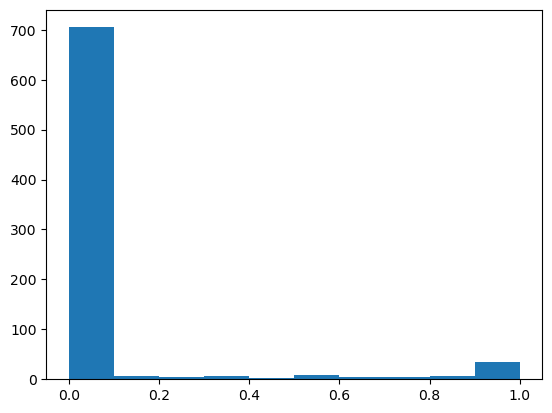

In [2]:
# dataSet=CIFAR10(root="../raw",train=True,transform=ToTensor())
dataSet=MNIST(root="../raw",train=True,transform=ToTensor())

image,label=dataSet[11]
nx=image.numel()
print(image.shape,label)
# fig,ax=plt.subplots()
# ax.imshow(image.permute(1,2,0))
# fig.set_size_inches(1,1)
plt.hist(image.flatten())

In [3]:
val_size = 10000
train_size = len(dataSet) - val_size

train_ds, val_ds = random_split(dataSet, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

As you know this dataset is not that huge, in reality the dataset can be much much
larger than this one and so we need to have batch size, that determines how much data we want to process at once. We need DataLoader that only loads and process the data based on the batch size. 

In [4]:
batch_size=128
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=0, pin_memory=True)

In [5]:
for imgs, lbls in train_loader:
    print(imgs.shape)
    break

torch.Size([128, 1, 28, 28])


In [6]:
class Cifar10Model(nn.Module):
    """Feedforward neural network with 3 hidden layer"""
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size1)
        self.linear2 = nn.Linear(hidden_size1, hidden_size2)
        self.linear3 = nn.Linear(hidden_size2, hidden_size3)
        self.linear4 = nn.Linear(hidden_size3, output_size)
    
    def forward(self, x):
        # flatten the given image
        x = x.view(x.size(0), -1)
        out = self.linear1(x)
        out = functional.relu(out)
        out = self.linear2(out)
        out = functional.relu(out)
        out = self.linear3(out)
        out = functional.relu(out)
        out = self.linear4(out)
        return out
    
    def accuracy(self, output, target):
        _, preds = torch.max(output, dim=1)
        return torch.tensor(torch.sum(preds == target).item() / preds.numel())
    
    def training_step(self, batch):
        imgs,labels = batch
        out = self.forward(imgs)
        loss = functional.cross_entropy(out,labels)
        return loss
    
    def validation_step(self, batch):
        imgs,labels = batch
        out = self.forward(imgs)
        loss = functional.cross_entropy(out,labels)
        acc = self.accuracy(out, labels)
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print(f"Epoch [{epoch}], val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")       
        

In [7]:
model = Cifar10Model(input_size=nx,hidden_size1=128,hidden_size2=64,hidden_size3=32,output_size=10)
for param in model.parameters():
    print(param.shape)

torch.Size([128, 784])
torch.Size([128])
torch.Size([64, 128])
torch.Size([64])
torch.Size([32, 64])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [8]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [9]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [10]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [11]:
# Model (on GPU)
model = to_device(model, device)
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.309126853942871, 'val_acc': 0.09236550331115723}]

In [12]:
history += fit(5, 0.05, model, train_loader, val_loader)
history += fit(5, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 0.5917, val_acc: 0.8222
Epoch [1], val_loss: 0.4219, val_acc: 0.8710
Epoch [2], val_loss: 0.3023, val_acc: 0.9112
Epoch [3], val_loss: 0.2551, val_acc: 0.9267
Epoch [4], val_loss: 0.2111, val_acc: 0.9397
Epoch [0], val_loss: 0.1876, val_acc: 0.9460
Epoch [1], val_loss: 0.1829, val_acc: 0.9463
Epoch [2], val_loss: 0.1761, val_acc: 0.9480
Epoch [3], val_loss: 0.1746, val_acc: 0.9478
Epoch [4], val_loss: 0.1666, val_acc: 0.9509


In [13]:
history += fit(5, 0.05, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1542, val_acc: 0.9537
Epoch [1], val_loss: 0.1463, val_acc: 0.9576
Epoch [2], val_loss: 0.1353, val_acc: 0.9581
Epoch [3], val_loss: 0.1337, val_acc: 0.9610
Epoch [4], val_loss: 0.1302, val_acc: 0.9613
